In [1]:
import torch
import os
from torch.utils.data import TensorDataset,ConcatDataset,DataLoader,WeightedRandomSampler
import matplotlib.pyplot as plt
from torch import nn
from torch.nn.functional import relu
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import train_test_split

device = 'mps'
path_to_pt_ekyn = f'../../sleep/pt_ekyn'

In [2]:
recording_filenames = os.listdir(path_to_pt_ekyn)
id = recording_filenames[0]
print(id)
X,y = torch.load(f'{path_to_pt_ekyn}/{id}')

X = X.unsqueeze(1)
X = X[:,:,::10] # 500 Hz -> 50 Hz

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,shuffle=True,stratify=y)
trainloader = DataLoader(TensorDataset(X_train,y_train),batch_size=512,shuffle=True)
testloader = DataLoader(TensorDataset(X_test,y_test),batch_size=512,shuffle=True)

Xi,yi = next(iter(trainloader))
print(Xi.shape,yi.shape,yi.argmax(dim=1).bincount())

Xi,yi = next(iter(testloader))
print(Xi.shape,yi.shape,yi.argmax(dim=1).bincount())

C4-0_PF.pt
torch.Size([512, 1, 500]) torch.Size([512, 3]) tensor([ 23, 252, 237])
torch.Size([512, 1, 500]) torch.Size([512, 3]) tensor([ 25, 251, 236])


In [ ]:
class SimpleNorm(nn.Module):
    def __init__(self,eps):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.tensor(1.0))
        self.shift = nn.Parameter(torch.tensor(0.0))
    def forward(self,x):
        mean = x.flatten().mean()
        std = x.flatten().std()
        x = (x - mean) / (std + self.eps)
        return x * self.scale + self.shift
    
class CNNSleepStager(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.norm = SimpleNorm(1e-5)
        self.c1 = nn.Conv1d(in_channels=1,out_channels=128,kernel_size=7)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(in_features=128,out_features=3)
    def forward(self,x):
        x = self.norm(x)
        x = self.c1(x)
        x = relu(x)
        x = self.gap(x)
        x = x.squeeze()
        x = self.classifier(x)
        return x
    
model = CNNSleepStager()
optimizer = torch.optim.AdamW(model.parameters(),lr=3e-3)
criterion = nn.CrossEntropyLoss()
model.to(device)

CNNSleepStager(
  (norm): SimpleNorm()
  (c1): Conv1d(1, 128, kernel_size=(7,), stride=(1,))
  (gap): AdaptiveAvgPool1d(output_size=1)
  (classifier): Linear(in_features=128, out_features=3, bias=True)
)

In [7]:
import numpy as np
window_size = 10
def moving_average(data, window_size=10):
    """Compute the moving average of a list."""
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

colors = {
    'Train': '#007AFF',  # Apple Blue
    'Test': '#FF9500'    # Apple Orange
}

trainlossi = []
testlossi = []

validation_frequency_epochs = 20

for epoch in tqdm(range(5000)):
    for Xi,yi in trainloader:
        Xi,yi = Xi.to(device),yi.to(device)
        optimizer.zero_grad()
        logits = model(Xi)
        loss = criterion(logits,yi)
        loss.backward()
        optimizer.step()
        trainlossi.append(loss.item())

    if epoch % validation_frequency_epochs == 0:
        # Calculate Test Loss
        with torch.no_grad():
            testlossi.append(torch.hstack([criterion(model(Xi.to(device)),yi.to(device)).cpu() for Xi,yi in testloader]).mean().item())

        # Plot Loss
        plt.figure()

        # First subplot - Loss
        plt.plot(trainlossi, label='Train Loss', color=colors['Train'], alpha=0.4, linewidth=1.5)
        
        # Moving average for loss
        if len(trainlossi) > window_size:
            plt.plot(range(window_size-1, len(trainlossi)), moving_average(trainlossi, window_size), label='Train Loss MA', color=colors['Train'], linestyle='--', linewidth=1.5)

        plt.plot(torch.linspace(0,len(trainlossi),len(testlossi)),testlossi, label='Test Loss', color=colors['Test'], alpha=1, linewidth=1.5)
        plt.savefig('loss.jpg')
        plt.close()

100%|██████████| 5000/5000 [20:41<00:00,  4.03it/s]


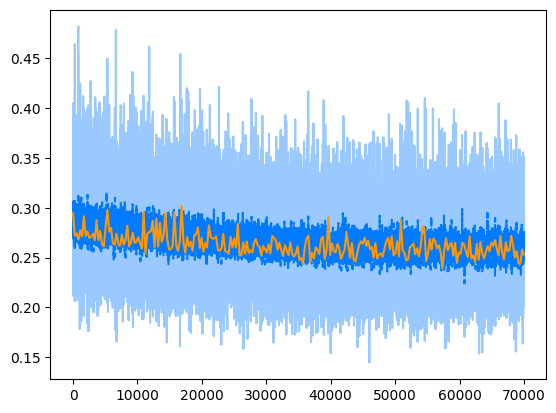

In [ ]:
# Plot Loss
plt.figure()

# First subplot - Loss
plt.plot(trainlossi, label='Train Loss', color=colors['Train'], alpha=0.4, linewidth=1.5)

# Moving average for loss
if len(trainlossi) > window_size:
    plt.plot(range(window_size-1, len(trainlossi)), moving_average(trainlossi, window_size), label='Train Loss MA', color=colors['Train'], linestyle='--', linewidth=1.5)

plt.plot(torch.linspace(0,len(trainlossi),len(testlossi)),testlossi, label='Test Loss', color=colors['Test'], alpha=1, linewidth=1.5)

In [8]:
y = torch.vstack([torch.vstack([model(Xi.to(device)).softmax(dim=1).argmax(dim=1).cpu(),yi.argmax(dim=1)]).T for Xi,yi in trainloader])
y_pred = y[:,0]
y_true = y[:,1]
print(classification_report(y_true=y_true,y_pred=y_pred))

y = torch.vstack([torch.vstack([model(Xi.to(device)).softmax(dim=1).argmax(dim=1).cpu(),yi.argmax(dim=1)]).T for Xi,yi in testloader])
y_pred = y[:,0]
y_true = y[:,1]
print(classification_report(y_true=y_true,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       378
           1       0.97      0.91      0.94      3351
           2       0.89      0.94      0.92      3183

    accuracy                           0.92      6912
   macro avg       0.85      0.85      0.85      6912
weighted avg       0.92      0.92      0.92      6912

              precision    recall  f1-score   support

           0       0.70      0.76      0.73        94
           1       0.97      0.91      0.94       838
           2       0.89      0.94      0.92       796

    accuracy                           0.92      1728
   macro avg       0.86      0.87      0.86      1728
weighted avg       0.92      0.92      0.92      1728

